# Pre-processing WBM Data for sea level estimates

In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import rasterio
from shapely.geometry import Point
import xarray as xr

### Filenames

In [2]:
main_directory = os.getcwd()

basin_csv_fn = '15min_flwdir_seg_endrh_v2_Mouth_ID.csv'
basin_tif_fn = 'MERIT_plus_15min_v1_IDs_wcrs.tif'
rgiids_wbasins_fn = 'RGI60_wMERIT_IDs.csv'

wbm_fp_primary = '/Volumes/TOSHIBA-WBM/NSLCT/'

# scenarios = ['ssp126']
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
gcm_names = ['BCC-CSM2-MR', 'CESM2', 'CESM2-WACCM', 'EC-Earth3', 'EC-Earth3-Veg', 'FGOALS-f3-L', 
             'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-MM']

vns = ['discharge_m3s_pg', 'discharge', 'glMelt']

# RGI data
rgi_fp = main_directory + '/../RGI/rgi60/00_rgi60_attribs/'
rgi_O1Id_colname = 'glacno'
rgi_glacno_float_colname = 'RGIId_float'
rgi_cols_drop = ['GLIMSId','BgnDate','EndDate','Status','Linkages']

### Process and export only datasets needed (netcdf files)
- yearly discharge_m3
- yearly discharge_m3s_pg
- yearly glmelt

In [3]:
overwrite = False

for gcm_name in gcm_names:
    for scenario in scenarios:
        
        for vn in vns:

            processed_fp = 'wbm_processed/' + vn + '-yearly/'
            if not os.path.exists(processed_fp):
                os.makedirs(processed_fp)

            processed_fn = 'wbm_' + gcm_name + '_' + scenario + '_2000_2099_v4-' + vn + '.nc'

            if not os.path.exists(processed_fp + processed_fn) or overwrite:
                print('processing ', gcm_name, scenario, vn)

                wbm_fp = wbm_fp_primary + 'NSLCT_' + gcm_name + '_' + scenario + '_2000_2099_v4/yearly/' + vn + '/'
        
                fns = []
                for fn in os.listdir(wbm_fp):
                    if fn.startswith('wbm') and fn.endswith('.nc'):
                        fns.append(fn)
                fns = sorted(fns)
        
                ds = None
                for fn in fns:
                    if ds is None:
                        ds = xr.open_dataset(wbm_fp + fn)
                    else:
                        ds_ind = xr.open_dataset(wbm_fp + fn)
                        ds = xr.concat([ds, ds_ind], 'time')

                # Drop the sigma
                ds = ds.drop_vars(vn + '_sigma')
                ds.to_netcdf(processed_fp + processed_fn)

### Load Outlet DataFrame

In [4]:
if os.path.exists(basin_csv_fn.replace('.csv','-wglac.csv')):
    outlet_df = pd.read_csv(basin_csv_fn.replace('.csv','-wglac.csv'))
else:
    outlet_df = pd.read_csv(basin_csv_fn, sep='\t')
    
    # Add glacier attributes like the lat and lon indices and whether glaciers or not
    lons = list(ds.lon.values)
    lats = list(ds.lat.values)

    outlet_df['glaciers'] = 0
    outlet_df['mouthlat_idx'] = np.nan
    outlet_df['mouthlon_idx'] = np.nan
    for nbasin, basin in enumerate(outlet_df.BasinName): 
        if nbasin%100==0:
            print(nbasin, basin)
        mouthlat = outlet_df.loc[nbasin,'MouthLat']
        mouthlon = outlet_df.loc[nbasin,'MouthLon']
        lon_idx = lons.index(ds.sel(lon=mouthlon, method='nearest').lon)
        lat_idx = lats.index(ds.sel(lat=mouthlat, method='nearest').lat)

        annual_discharge_pg = ds.discharge_m3s_pg[:,lat_idx,lon_idx].values.sum()

        if annual_discharge_pg > 0:
            outlet_df.loc[nbasin,'glaciers'] = 1
            outlet_df.loc[nbasin,'mouthlat_idx'] = lat_idx
            outlet_df.loc[nbasin,'mouthlon_idx'] = lon_idx
    
    # Export
    outlet_df.to_csv(basin_csv_fn.replace('.csv','-wglac.csv'), index=False)
    
outlet_df

,BasinID,BasinName,MouthLon,MouthLat,X,Y,BasinArea,Endorheic,SeaBasinCode,SeaBasinName,glaciers,mouthlat_idx,mouthlon_idx
0,1,Amazon,-50.625,-0.375,517,341,5945331.07,0,32,Atlantic Ocean,1,238.0,517.0
1,2,Zaire,12.375,-6.125,769,364,3697581.39,0,32,Atlantic Ocean,1,215.0,769.0
2,3,NaN,51.125,39.125,924,183,3278637.42,1,0,NaN,1,396.0,924.0
3,4,Nile,30.375,31.375,841,214,3110922.57,0,2,Mediterranean Sea,1,365.0,841.0
4,5,Parana,-58.375,-34.125,486,476,3002826.39,0,32,Atlantic Ocean,1,103.0,486.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33168,36387,NaN,-27.375,83.625,610,5,85.97,0,0,NaN,0,NaN,NaN
33169,36388,NaN,-32.625,83.625,589,5,85.97,0,0,NaN,0,NaN,NaN
33170,36389,NaN,-29.625,83.625,601,5,85.97,0,0,NaN,0,NaN,NaN
33171,36390,NaN,-29.375,83.625,602,5,85.97,0,0,NaN,0,NaN,NaN


### Subset to only glacierized basins
Note that basin csv file’s X and Y are associated with the raster; not the netcdf file.

In [5]:
outlet_df_glac = outlet_df.loc[outlet_df['glaciers'] == 1]
outlet_df_glac = outlet_df_glac.sort_values('BasinID')
outlet_df_glac.reset_index(inplace=True, drop=True)
outlet_df_glac[0:25]

,BasinID,BasinName,MouthLon,MouthLat,X,Y,BasinArea,Endorheic,SeaBasinCode,SeaBasinName,glaciers,mouthlat_idx,mouthlon_idx
0,1,Amazon,-50.625,-0.375,517,341,5945331.07,0,32,Atlantic Ocean,1,238.0,517.0
1,2,Zaire,12.375,-6.125,769,364,3697581.39,0,32,Atlantic Ocean,1,215.0,769.0
2,3,NaN,51.125,39.125,924,183,3278637.42,1,0,NaN,1,396.0,924.0
3,4,Nile,30.375,31.375,841,214,3110922.57,0,2,Mediterranean Sea,1,365.0,841.0
4,5,Parana,-58.375,-34.125,486,476,3002826.39,0,32,Atlantic Ocean,1,103.0,486.0
5,6,Mississippi,-89.375,28.875,362,224,2987909.46,0,32,Atlantic Ocean,1,355.0,362.0
6,7,Yenisei,83.375,70.875,1053,56,2559809.26,0,146,Kara Sea,1,523.0,1053.0
7,8,Ob,69.875,66.375,999,74,2557932.52,0,146,Kara Sea,1,505.0,999.0
8,9,Lena,129.125,72.125,1236,51,2462908.17,0,148,Laptev Sea,1,528.0,1236.0
9,11,Chang Jiang,121.125,31.875,1204,212,1930063.73,0,102,Yellow Sea,1,367.0,1204.0


In [6]:
outlet_df_glac_exor = outlet_df_glac.loc[outlet_df_glac['Endorheic'] == 0]
outlet_df_glac_exor.reset_index(inplace=True, drop=True)
outlet_df_glac_exor

,BasinID,BasinName,MouthLon,MouthLat,X,Y,BasinArea,Endorheic,SeaBasinCode,SeaBasinName,glaciers,mouthlat_idx,mouthlon_idx
0,1,Amazon,-50.625,-0.375,517,341,5945331.07,0,32,Atlantic Ocean,1,238.0,517.0
1,2,Zaire,12.375,-6.125,769,364,3697581.39,0,32,Atlantic Ocean,1,215.0,769.0
2,4,Nile,30.375,31.375,841,214,3110922.57,0,2,Mediterranean Sea,1,365.0,841.0
3,5,Parana,-58.375,-34.125,486,476,3002826.39,0,32,Atlantic Ocean,1,103.0,486.0
4,6,Mississippi,-89.375,28.875,362,224,2987909.46,0,32,Atlantic Ocean,1,355.0,362.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4040,36289,NaN,-77.625,82.875,409,8,96.03,0,128,Arctic subocean,1,571.0,409.0
4041,36291,NaN,-79.125,82.875,403,8,96.03,0,128,Arctic subocean,1,571.0,403.0
4042,36304,NaN,-67.875,82.875,448,8,96.03,0,128,Arctic subocean,1,571.0,448.0
4043,36324,NaN,-38.125,83.125,567,7,92.68,0,0,NaN,1,572.0,567.0


### Load Raster of basin boundaries for glmelt
Basin ID in the .csv is the same as the raster values

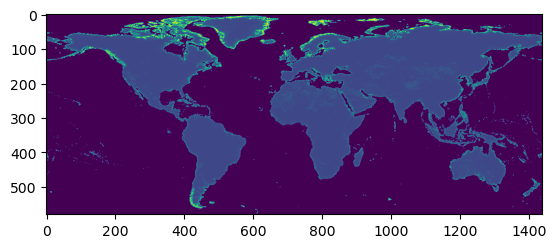

In [7]:
src = rasterio.open(basin_tif_fn)
basin_raster = src.read(1)
# basin_raster[basin_raster == 23] = 1e6
plt.imshow(basin_raster)
plt.show()

#### Code to check that the basin Ids are properly aligned with the raster
3/5/2024 - confirmed they are

In [8]:
# # Derive lat/lons of raster so indexing can be done properly
# height = basin_raster.shape[0]
# width = basin_raster.shape[1]
# cols, rows = np.meshgrid(np.arange(width), np.arange(height))
# xs, ys = rasterio.transform.xy(src.transform, rows, cols)
# lons_raster = np.array(xs)[0,:]
# lats_raster = np.array(ys)[:,0]

# assert np.max(ds.lon.values - lons_raster) == 0, 'Check alignment between raster and xarray dataset'
# assert np.max(ds.lat.values - lats_raster[::-1]) == 0, 'Check alignment between raster and xarray dataset'

# # Add ID to the dataframe to check
# outlet_df_glac['basin_raster_id'] = np.nan
# for nbasin, basin in enumerate(outlet_df_glac.BasinName.values):
#     mouthlat = outlet_df_glac.loc[nbasin,'MouthLat']
#     mouthlon = outlet_df_glac.loc[nbasin,'MouthLon']
#     print(mouthlat, mouthlon)

#     lat_idx = np.abs(lats_raster - mouthlat).argmin()
#     lon_idx = np.abs(lons_raster - mouthlon).argmin()

#     raster_value = basin_raster[lat_idx, lon_idx]

#     outlet_df_glac.loc[nbasin, 'basin_raster_id'] = raster_value
#     # print(nbasin, basin)

# Estimate glacier melt input + discharge at outlets
Verified values agree with those from Alex (3/5/2024)

#### Flip basin_raster such that the indices of the raster and ds align

In [9]:
basin_raster_flipped = np.flip(basin_raster, axis=0)

#### Select the indices of the basin and then select the glacier values

In [10]:
overwrite_components = False

time_len = 84
for scenario in scenarios:

    ds_processed_fp = 'wbm_processed/basin_components_yearly/'
    ds_processed_fn = 'wbm_' + scenario + '_2016_2099_v4-basin_components_yearly.nc'
    if not os.path.exists(ds_processed_fp):
        os.makedirs(ds_processed_fp)

    if not os.path.exists(ds_processed_fp + ds_processed_fn) or overwrite_components:

        basin_q_array = np.zeros((len(gcm_names), outlet_df_glac.shape[0], time_len))
        basin_qpg_array = np.zeros((len(gcm_names), outlet_df_glac.shape[0], time_len))
        basin_glmelt_array = np.zeros((len(gcm_names), outlet_df_glac.shape[0], time_len))
        
        for ngcm, gcm_name in enumerate(gcm_names):

            # print('processing', scenario, gcm_name)

            # ----- Load datasets -----
            discharge_fp = 'wbm_processed/discharge-yearly/'
            discharge_fn = 'wbm_' + gcm_name + '_' + scenario + '_2000_2099_v4-discharge.nc'
            ds_q = xr.open_dataset(discharge_fp + discharge_fn)
    
            discharge_pg_fp = 'wbm_processed/discharge_m3s_pg-yearly/'
            discharge_pg_fn = 'wbm_' + gcm_name + '_' + scenario + '_2000_2099_v4-discharge_m3s_pg.nc'
            ds_q_pg = xr.open_dataset(discharge_pg_fp + discharge_pg_fn)
    
            melt_fp = 'wbm_processed/glMelt-yearly/'
            melt_fn = 'wbm_' + gcm_name + '_' + scenario + '_2000_2099_v4-glMelt.nc'
            ds_melt = xr.open_dataset(melt_fp + melt_fn)
    
            # Global glacier runoff reaching ocean (exorheic outlets only)
            mouthlat_idxs = outlet_df_glac_exor['mouthlat_idx'].values.astype(int)
            mouthlon_idxs = outlet_df_glac_exor['mouthlon_idx'].values.astype(int)
            
            q = ds_q.discharge.values
            q_outlet = np.nansum(q[:,mouthlat_idxs, mouthlon_idxs], axis=1)
            q_pg = ds_q_pg.discharge_m3s_pg.values
            q_pg_outlet = np.nansum(q_pg[:,mouthlat_idxs, mouthlon_idxs], axis=1)
            glmelt_global = np.nansum(ds_melt.glMelt.values, axis=(1,2))

            print(scenario, gcm_name, (q_pg_outlet / glmelt_global).mean(0))
    
            # basin_q_array[ngcm, 0,:] = q_outlet
            # basin_qpg_array[ngcm, 0,:] = q_pg_outlet
            # basin_glmelt_array[ngcm, 0,:] = glmelt_global
            
            # Loop through basins
            for nbasin, basin in enumerate(outlet_df_glac.BasinName.values):
                basin_id = outlet_df_glac.loc[nbasin, 'BasinID']
                
                mouthlat_idx = int(outlet_df_glac.loc[nbasin, 'mouthlat_idx'])
                mouthlon_idx = int(outlet_df_glac.loc[nbasin, 'mouthlon_idx'])
                
                q_outlet = ds_q.discharge[:,mouthlat_idx, mouthlon_idx].values
                q_pg_outlet = ds_q_pg.discharge_m3s_pg[:,mouthlat_idx, mouthlon_idx].values
    
                raster_idxs = np.where(basin_raster_flipped == basin_id)
                glmelt = ds_melt.glMelt.values
                glmelt_basin = np.nansum(glmelt[:,raster_idxs[0], raster_idxs[1]], axis=1)
    
                basin_q_array[ngcm, nbasin,:] = q_outlet
                basin_qpg_array[ngcm, nbasin,:] = q_pg_outlet
                basin_glmelt_array[ngcm, nbasin,:] = glmelt_basin
        
        # ----- Export as netcdf -----
        years = np.array(list(pd.DatetimeIndex(ds_melt.time.values).year))
        basins = np.arange(basin_q_array.shape[1])
        basin_ids_array = outlet_df_glac.BasinID.values

        ds_processed = xr.Dataset(
            data_vars=dict(
                discharge=(["gcm", "basin", "year"], basin_q_array),
                discharge_pg=(["gcm", "basin", "year"], basin_qpg_array),
                glmelt=(["gcm", "basin", "year"], basin_glmelt_array),
                basin_ids=(["basin"], basin_ids_array),
                gcms=(["gcm"], gcm_names), 
            ),
            coords=dict(
                year=years,
                basin=basins,
                gcm=gcm_names
            ),
            attrs=dict(description="Processed WBM data"),
        )

        ds_processed.to_netcdf(ds_processed_fp + ds_processed_fn)

# Statistics by basin of fraction reaching ocean
Note in plots separate exorheic, endorheic, and non-glaciated basins to support easier color palletes
- some non-glaciated basins have runoff due to interbasin transfers

In [11]:
outlet_df_glac.BasinID.values.shape

(4764,)

/var/folders/wz/xj3ys3v57z71zx2d2vhczznw0000gn/T/ipykernel_1682/2803548122.py:8: RuntimeWarning: divide by zero encountered in divide
  glfrac = ds.discharge_pg.values / ds.glmelt.values
/var/folders/wz/xj3ys3v57z71zx2d2vhczznw0000gn/T/ipykernel_1682/2803548122.py:8: RuntimeWarning: invalid value encountered in divide
  glfrac = ds.discharge_pg.values / ds.glmelt.values
/Users/drounce/opt/anaconda3/envs/data_analytics_env/lib/python3.12/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


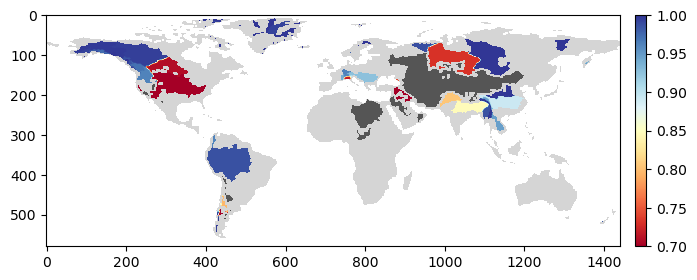

/var/folders/wz/xj3ys3v57z71zx2d2vhczznw0000gn/T/ipykernel_1682/2803548122.py:8: RuntimeWarning: divide by zero encountered in divide
  glfrac = ds.discharge_pg.values / ds.glmelt.values
/var/folders/wz/xj3ys3v57z71zx2d2vhczznw0000gn/T/ipykernel_1682/2803548122.py:8: RuntimeWarning: invalid value encountered in divide
  glfrac = ds.discharge_pg.values / ds.glmelt.values
/Users/drounce/opt/anaconda3/envs/data_analytics_env/lib/python3.12/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


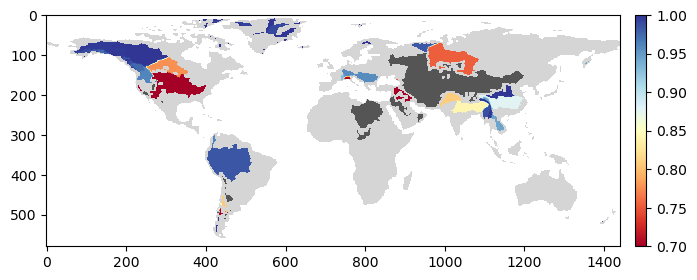

/var/folders/wz/xj3ys3v57z71zx2d2vhczznw0000gn/T/ipykernel_1682/2803548122.py:8: RuntimeWarning: divide by zero encountered in divide
  glfrac = ds.discharge_pg.values / ds.glmelt.values
/var/folders/wz/xj3ys3v57z71zx2d2vhczznw0000gn/T/ipykernel_1682/2803548122.py:8: RuntimeWarning: invalid value encountered in divide
  glfrac = ds.discharge_pg.values / ds.glmelt.values
/Users/drounce/opt/anaconda3/envs/data_analytics_env/lib/python3.12/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


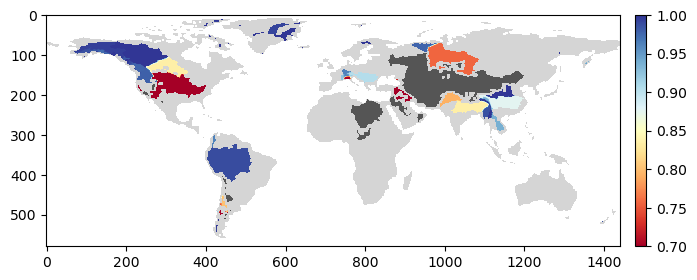

/var/folders/wz/xj3ys3v57z71zx2d2vhczznw0000gn/T/ipykernel_1682/2803548122.py:8: RuntimeWarning: divide by zero encountered in divide
  glfrac = ds.discharge_pg.values / ds.glmelt.values
/var/folders/wz/xj3ys3v57z71zx2d2vhczznw0000gn/T/ipykernel_1682/2803548122.py:8: RuntimeWarning: invalid value encountered in divide
  glfrac = ds.discharge_pg.values / ds.glmelt.values
/Users/drounce/opt/anaconda3/envs/data_analytics_env/lib/python3.12/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


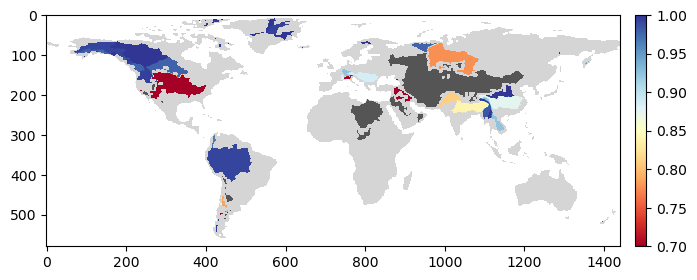

In [12]:
for scenario in scenarios:
    ds_processed_fp = 'wbm_processed/basin_components_yearly/'
    ds_processed_fn = 'wbm_' + scenario + '_2016_2099_v4-basin_components_yearly.nc'

    ds = xr.open_dataset(ds_processed_fp + ds_processed_fn)

    # Calculate the fraction of runoff that reaches the ocean
    glfrac = ds.discharge_pg.values / ds.glmelt.values
    glfrac_gcm_basin_mean = glfrac.mean(2)

    # multi-gcm mean and stdev
    glfrac_basin_mean = glfrac_gcm_basin_mean.mean(0)
    glfrac_basin_std = glfrac_gcm_basin_mean.std(0)

    # dictionary to support plotting basin colors differently
    basin_frac_dict = dict(zip(outlet_df_glac.BasinID.values, glfrac_basin_mean))
    # print(scenario, 'global mean/std:', glfrac_basin_mean[0], glfrac_basin_std[0])

    # ----- Raster Generation -----
    src = rasterio.open(basin_tif_fn)
    
    # Exorheic glaciated basins
    basin_raster_frac_exor = np.zeros(basin_raster.shape)
    basin_raster_frac_exor[:] = np.nan
    # Endorheic glaciated basins
    basin_raster_frac_endo = np.zeros(basin_raster.shape)
    basin_raster_frac_endo[:] = np.nan
    # Non-glaciated basins
    # basin_raster_noglac = np.zeros(basin_raster.shape)
    # basin_raster_noglac[:] = np.nan
    basin_raster_noglac = np.zeros(basin_raster.shape)
    basin_raster_noglac[:] = np.nan
    basin_raster_noglac[basin_raster > -9999] = 0
    
    # Basin IDs
    basin_ids_glac = list(outlet_df_glac['BasinID'].values)
    basin_ids_glac_exor = list(outlet_df_glac_exor['BasinID'].values)
    for nbasin, basin_id in enumerate(outlet_df_glac['BasinID'].values):
        if basin_id in list(basin_ids_glac_exor):
            basin_raster_frac_exor[basin_raster == basin_id] = basin_frac_dict[basin_id]
        elif basin_id in list(basin_ids_glac):
            basin_raster_frac_endo[basin_raster == basin_id] = 0
        
        # basin_raster_noglac[basin_raster == basin_id] = np.nan
        # elif basin_id > 0:
        #     basin_raster_noglac[basin_raster == basin_id] = 0
    
    # ----- PLOT OF FRACTION REMAINING -----
    plot_frac_min = 0.7
    plot_frac_max = 1
    cmap_frac = 'RdYlBu'
    # cmap_frac = 'winter_r'
    fig, ax = plt.subplots(1,1, squeeze=False, sharex=False, sharey=False,
                          gridspec_kw={'wspace':0.5, 'hspace':0.3})
    # exorheic basins (colored by fraction that reaches the ocean)
    pcm = ax[0,0].imshow(basin_raster_frac_exor, vmin=plot_frac_min, vmax=plot_frac_max, cmap=cmap_frac, zorder=3)
    # endorheic basins (dark grey)
    pcm2 = ax[0,0].imshow(basin_raster_frac_endo, vmin=-0.5, vmax=1, cmap='gray', zorder=2)
    # non-glaciated basin (light grey)
    pcm3 = ax[0,0].imshow(basin_raster_noglac, vmin=-1, vmax=0.2, cmap='gray', zorder=1)
    
    # Divide existing axes and create
    # new axes at right side of image
    divider = make_axes_locatable(ax[0,0])
    cax = divider.append_axes("right", size="2%", pad=0.15)
    # cb = fig.colorbar(pcm, fraction=0.047*height_in/width_in, pad=0.04)
    cb = fig.colorbar(pcm, cax=cax)
    
    fig.set_size_inches(8,3)
    
    fig_fp = 'wbm_processed/_figures/'
    if not os.path.exists(fig_fp):
        os.makedirs(fig_fp)
    fig.savefig(fig_fp + 'wbm_glmelt_frac2ocean_' + scenario + '.png', dpi=900)
    
    plt.show()

# Pair glaciers with the basins

In [13]:
def selectglaciersrgitable(glac_no=None, rgi_regionsO1=None, rgi_regionsO2='all', rgi_glac_number='all',
                           rgi_fp=rgi_fp, 
                           rgi_cols_drop=rgi_cols_drop,
                           rgi_O1Id_colname=rgi_O1Id_colname,
                           rgi_glacno_float_colname=rgi_glacno_float_colname,
                           indexname='GlaNo',
                           include_landterm=True,include_laketerm=True,include_tidewater=True,
                           glac_no_skip=None,
                           min_glac_area_km2=0):
    """
    Select all glaciers to be used in the model run according to the regions and glacier numbers defined by the RGI
    glacier inventory. This function returns the rgi table associated with all of these glaciers.

    glac_no : list of strings
        list of strings of RGI glacier numbers (e.g., ['1.00001', '13.00001'])
    rgi_regionsO1 : list of integers
        list of integers of RGI order 1 regions (e.g., [1, 13])
    rgi_regionsO2 : list of integers or 'all'
        list of integers of RGI order 2 regions or simply 'all' for all the order 2 regions
    rgi_glac_number : list of strings
        list of RGI glacier numbers without the region (e.g., ['00001', '00002'])

    Output: Pandas DataFrame of the glacier statistics for each glacier in the model run
    (rows = GlacNo, columns = glacier statistics)
    """
    if glac_no is not None:
        glac_no_byregion = {}
        rgi_regionsO1 = [int(i.split('.')[0]) for i in glac_no]
        rgi_regionsO1 = list(set(rgi_regionsO1))
        for region in rgi_regionsO1:
            glac_no_byregion[region] = []
        for i in glac_no:
            region = i.split('.')[0]
            glac_no_only = i.split('.')[1]
            glac_no_byregion[int(region)].append(glac_no_only)

        for region in rgi_regionsO1:
            glac_no_byregion[region] = sorted(glac_no_byregion[region])

    # Create an empty dataframe
    rgi_regionsO1 = sorted(rgi_regionsO1)
    glacier_table = pd.DataFrame()
    for region in rgi_regionsO1:

        if glac_no is not None:
            rgi_glac_number = glac_no_byregion[region]

#        if len(rgi_glac_number) < 50:

        for i in os.listdir(rgi_fp):
            if i.startswith(str(region).zfill(2)) and i.endswith('.csv'):
                rgi_fn = i
        try:
            csv_regionO1 = pd.read_csv(rgi_fp + rgi_fn)
        except:
            csv_regionO1 = pd.read_csv(rgi_fp + rgi_fn, encoding='latin1')
        
        # Populate glacer_table with the glaciers of interest
        if rgi_regionsO2 == 'all' and rgi_glac_number == 'all':
            print("All glaciers within region(s) %s are included in this model run." % (region))
            if glacier_table.empty:
                glacier_table = csv_regionO1
            else:
                glacier_table = pd.concat([glacier_table, csv_regionO1], axis=0)
        elif rgi_regionsO2 != 'all' and rgi_glac_number == 'all':
            print("All glaciers within subregion(s) %s in region %s are included in this model run." %
                  (rgi_regionsO2, region))
            for regionO2 in rgi_regionsO2:
                if glacier_table.empty:
                    glacier_table = csv_regionO1.loc[csv_regionO1['O2Region'] == regionO2]
                else:
                    glacier_table = (pd.concat([glacier_table, csv_regionO1.loc[csv_regionO1['O2Region'] ==
                                                                                regionO2]], axis=0))
        else:
            if len(rgi_glac_number) < 20:
                print("%s glaciers in region %s are included: %s" % (len(rgi_glac_number), region, rgi_glac_number))
            else:
                print("%s glaciers in region %s are included" % (len(rgi_glac_number), region))
                
            rgiid_subset = ['RGI60-' + str(region).zfill(2) + '.' + x for x in rgi_glac_number] 
            rgiid_all = list(csv_regionO1.RGIId.values)
            rgi_idx = [rgiid_all.index(x) for x in rgiid_subset if x in rgiid_all]
            if glacier_table.empty:
                glacier_table = csv_regionO1.loc[rgi_idx]
            else:
                glacier_table = (pd.concat([glacier_table, csv_regionO1.loc[rgi_idx]],
                                           axis=0))
                    
    glacier_table = glacier_table.copy()
    # reset the index so that it is in sequential order (0, 1, 2, etc.)
    glacier_table.reset_index(inplace=True)
    # drop connectivity 2 for Greenland and Antarctica
    glacier_table = glacier_table.loc[glacier_table['Connect'].isin([0,1])]
    glacier_table.reset_index(drop=True, inplace=True)
    # change old index to 'O1Index' to be easier to recall what it is
    glacier_table.rename(columns={'index': 'O1Index'}, inplace=True)
    # Record the reference date
    glacier_table['RefDate'] = glacier_table['BgnDate']
    # if there is an end date, then roughly average the year
    enddate_idx = glacier_table.loc[(glacier_table['EndDate'] > 0), 'EndDate'].index.values
    glacier_table.loc[enddate_idx,'RefDate'] = (
            np.mean((glacier_table.loc[enddate_idx,['BgnDate', 'EndDate']].values / 10**4).astype(int),
                    axis=1).astype(int) * 10**4 + 9999)
    # drop columns of data that is not being used
    glacier_table.drop(rgi_cols_drop, axis=1, inplace=True)
    # add column with the O1 glacier numbers
    glacier_table[rgi_O1Id_colname] = (
            glacier_table['RGIId'].str.split('.').apply(pd.Series).loc[:,1].astype(int))
    glacier_table['rgino_str'] = [x.split('-')[1] for x in glacier_table.RGIId.values]
#    glacier_table[rgi_glacno_float_colname] = (np.array([np.str.split(glacier_table['RGIId'][x],'-')[1]
#                                                    for x in range(glacier_table.shape[0])]).astype(float))
    glacier_table[rgi_glacno_float_colname] = (np.array([x.split('-')[1] for x in glacier_table['RGIId']]
#            [np.str.split(glacier_table['RGIId'][x],'-')[1]
#                                                    for x in range(glacier_table.shape[0])]
            ).astype(float))
    # set index name
    glacier_table.index.name = indexname
    # Longitude between 0-360deg (no negative)
    glacier_table['CenLon_360'] = glacier_table['CenLon']
    glacier_table.loc[glacier_table['CenLon'] < 0, 'CenLon_360'] = (
            360 + glacier_table.loc[glacier_table['CenLon'] < 0, 'CenLon_360'])
    # Subset glaciers based on their terminus type
    termtype_values = []
    if include_landterm:
        termtype_values.append(0)
        # assume dry calving, regenerated, and not assigned are land-terminating
        termtype_values.append(3)
        termtype_values.append(4)
        termtype_values.append(9)
    if include_tidewater:
        termtype_values.append(1)
        # assume shelf-terminating glaciers are tidewater
        termtype_values.append(5)
    if include_laketerm:
        termtype_values.append(2)
    glacier_table = glacier_table.loc[glacier_table['TermType'].isin(termtype_values)]
    glacier_table.reset_index(inplace=True, drop=True)
    # Glacier number with no trailing zeros
    glacier_table['glacno'] = [str(int(x.split('-')[1].split('.')[0])) + '.' + x.split('-')[1].split('.')[1]
                               for x in glacier_table.RGIId]
    
    # Remove glaciers below threshold
    glacier_table = glacier_table.loc[glacier_table['Area'] > min_glac_area_km2,:]
    glacier_table.reset_index(inplace=True, drop=True)

    # Remove glaciers that are meant to be skipped
    if glac_no_skip is not None:
        glac_no_all = list(glacier_table['glacno'])
        glac_no_unique = [x for x in glac_no_all if x not in glac_no_skip]
        unique_idx = [glac_no_all.index(x) for x in glac_no_unique]
        glacier_table = glacier_table.loc[unique_idx,:]
        glacier_table.reset_index(inplace=True, drop=True)

    # print("This study is focusing on %s glaciers in region %s" % (glacier_table.shape[0], rgi_regionsO1))

    return glacier_table

In [14]:
src = rasterio.open(basin_tif_fn)
data = src.read(1)
full_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
print(full_extent)

subset = data[0:150,0:250]

[-180.0, 180.0, -60.0, 85.0]


In [15]:
src.meta

{'driver': 'GTiff',
 'dtype': 'int32',
 'nodata': -9999.0,
 'width': 1440,
 'height': 580,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.25, 0.0, -180.0,
        0.0, -0.25, 85.0)}

In [16]:
overwrite_rgiids_wbasins_fn = False
if os.path.exists(rgiids_wbasins_fn) and not overwrite_rgiids_wbasins_fn:
    rgi_gdf_wbasins = gpd.read_file(rgiids_wbasins_fn)

    rgi_gdf_wbasins_csv = pd.read_csv(rgiids_wbasins_fn)
    lons = rgi_gdf_wbasins_csv['CenLon'].values
    lats = rgi_gdf_wbasins_csv['CenLat'].values
    lons_lats = zip(lons, lats)
    geometry = [Point(lon,lat) for lon, lat in lons_lats]
    rgi_gdf_wbasins = gpd.GeoDataFrame(rgi_gdf_wbasins_csv, geometry=geometry, crs="EPSG:4326")
    
else:
    print('process basins for each RGIId')
    
    rgi_gdf_wbasins = None
    # for region in [1,15]:
    for region in np.arange(1,19):
        print(region)
        main_glac_rgi = selectglaciersrgitable(rgi_regionsO1=[region])
        
        lons = main_glac_rgi['CenLon'].values
        lats = main_glac_rgi['CenLat'].values
        lons_lats = zip(lons, lats)
        geometry = [Point(lon,lat) for lon, lat in lons_lats]
        rgi_gdf = gpd.GeoDataFrame(main_glac_rgi, geometry=geometry, crs="EPSG:4326")
        # rgi_gdf = rgi_gdf.to_crs(src.crs)
    
        coord_list = zip(rgi_gdf['geometry'].x, rgi_gdf['geometry'].y)
        rgi_gdf['MeritID'] = [x[0] for x in src.sample(coord_list)]
    
        if rgi_gdf_wbasins is None:
            rgi_gdf_wbasins = rgi_gdf
        else:
            rgi_gdf_wbasins = pd.concat([rgi_gdf_wbasins, rgi_gdf], ignore_index=True)
    rgi_gdf_wbasins.to_csv(rgiids_wbasins_fn, index=False,
                           columns=['RGIId', 'CenLon', 'CenLat', 'O1Region', 'O2Region', 'Area', 'Name', 'MeritID'])

In [17]:
rgi_gdf_wbasins

,RGIId,CenLon,CenLat,O1Region,O2Region,Area,Name,MeritID,geometry
0,RGI60-01.00001,-146.823,63.6890,1,2,0.360,NaN,306,POINT (-146.82300 63.68900)
1,RGI60-01.00002,-146.668,63.4040,1,2,0.558,NaN,306,POINT (-146.66800 63.40400)
2,RGI60-01.00003,-146.080,63.3760,1,2,1.685,NaN,24,POINT (-146.08000 63.37600)
3,RGI60-01.00004,-146.120,63.3810,1,2,3.681,NaN,24,POINT (-146.12000 63.38100)
4,RGI60-01.00005,-147.057,63.5510,1,2,2.573,NaN,24,POINT (-147.05700 63.55100)
...,...,...,...,...,...,...,...,...,...
212790,RGI60-18.03533,170.354,-43.4215,18,1,0.189,NaN,5735,POINT (170.35400 -43.42150)
212791,RGI60-18.03534,170.349,-43.4550,18,1,0.040,NaN,5735,POINT (170.34900 -43.45500)
212792,RGI60-18.03535,170.351,-43.4400,18,1,0.184,NaN,5735,POINT (170.35100 -43.44000)
212793,RGI60-18.03536,170.364,-43.4106,18,1,0.111,NaN,5735,POINT (170.36400 -43.41060)


In [18]:
# print(rgi_gdf_wbasins.loc[569, ['RGIId', 'Name', 'MeritID']]) # Gulkana
print(rgi_gdf_wbasins.loc[rgi_gdf_wbasins['RGIId']=='RGI60-01.00570', ['RGIId', 'Name', 'MeritID']],'\n') # Gulkana
print(rgi_gdf_wbasins.loc[rgi_gdf_wbasins['RGIId']=='RGI60-15.03733', ['RGIId', 'Name', 'MeritID']]) # Khumbu

              RGIId             Name  MeritID
569  RGI60-01.00570  Gulkana Glacier       24 

                 RGIId Name  MeritID
181024  RGI60-15.03733  NaN       14


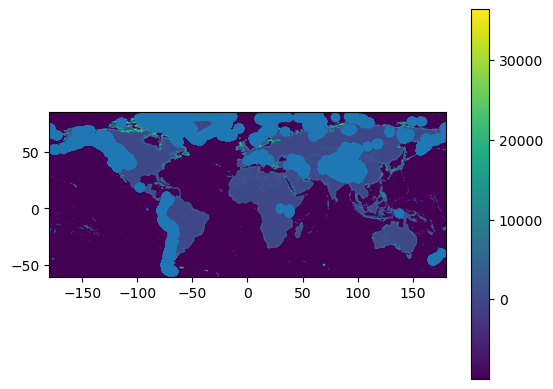

In [19]:
f,ax = plt.subplots()
m = ax.imshow(data, extent=full_extent)
rgi_gdf_wbasins.plot(ax=ax)
plt.colorbar(m, ax=ax)
plt.show()

Manually checked that all glaciers are affiliated with a BasinID on 8/13/2024.

# Glacier Mass Time Series per Basin

In [20]:
pygem_output_fp = '/Users/drounce/Documents/HiMAT/spc_backup/nsidc/glacier_stats/'
glac_vns = ['mass_annual', 'mass_bsl_annual']
# glac_vns = ['mass_bsl_annual']
ds_vn_dict = {'area_annual': 'glac_area_annual', 
              'mass_annual': 'glac_mass_annual',
              'mass_bsl_annual': 'glac_mass_bsl_annual',
              'runoff_monthly': 'glac_runoff_fixed_monthly'}
regions = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
# regions = [1]

aggregate_mass_to_basins = True

#### Dictionary linking RGIIds to MeritID

In [21]:
group_dict = dict(zip(rgi_gdf_wbasins.RGIId, rgi_gdf_wbasins.MeritID))
groups_all = list(np.unique(rgi_gdf_wbasins.MeritID))

In [22]:
if aggregate_mass_to_basins:
    # Set up processing
    reg_mass_all = {}
    reg_mass_bsl_all = {}
    # reg_area_all = {} 
    # reg_runoff_all = {}
    
    for group in groups_all:
        reg_mass_all[group] = {}
        reg_mass_bsl_all[group] = {}
        # reg_area_all[group] = {}
        # reg_runoff_all[group] = {}
    
        for scenario in scenarios:
            reg_mass_all[group][scenario] = None
            reg_mass_bsl_all[group][scenario] = None
            # reg_area_all[group][scenario] = None
            # reg_runoff_all[group][scenario] = None

    # Load and aggregate data
    for scenario in scenarios:
        count_glaciers_total = 0
        for glac_vn in glac_vns:
            for reg in regions:
    
                print(reg, scenario, glac_vn)
                
                # ----- NETCDF FILEPATHS AND FILENAMES -----
                # Filenames
                fp_reg_vn = pygem_output_fp + glac_vn + '/' + str(reg).zfill(2) + '/'
                
                fn_batches = []
                for fn in os.listdir(fp_reg_vn):
                    if glac_vn in fn and scenario in fn:
                        fn_batches.append(fn)
         
                # Load data
                vn_scenario = None
                for fn in fn_batches:
    
                    ds_batch = xr.open_dataset(fp_reg_vn + fn)
                    
                    ds_vn = ds_vn_dict[glac_vn]
                    
                    reg_vn_scenario_raw = ds_batch[ds_vn].values

                    # Select specific GCM data
                    gcm_dict = {}
                    for i in ds_batch.Climate_Model.attrs.keys():
                        try:
                            # print(int(i), ds_batch.Climate_Model.attrs[i])
                            gcm_dict[int(i)] = ds_batch.Climate_Model.attrs[i]
                        except:
                            pass
                    ds_gcm_names = []
                    for i in ds_batch.Climate_Model.values:
                        ds_gcm_names.append(gcm_dict[i])
                    
                    ds_gcm_idxs = []
                    for gcm_name in gcm_names:
                        ds_gcm_idxs.append(ds_gcm_names.index(gcm_name))
                    ds_gcm_idxs
                    
                    reg_vn_scenario = reg_vn_scenario_raw[ds_gcm_idxs,:,:]

                    # Aggregate
                    if vn_scenario is None:
                        vn_scenario = reg_vn_scenario
                        vn_rgiids = list(ds_batch.RGIId.values)
                        years = ds_batch.year.values
                    else:
                        vn_scenario = np.concatenate((vn_scenario, reg_vn_scenario), axis=1)
                        vn_rgiids.extend(list(ds_batch.RGIId.values))
    
                # Load Glaciers
                glacno_list = [x.split('-')[1] for x in vn_rgiids]
                main_glac_rgi_reg = selectglaciersrgitable(glac_no=glacno_list)
    
                # Add trailing zero to ensure RGIIds are appropriate
                if reg < 10:
                    vn_rgiids = ['RGI60-0' + x for x in glacno_list]
                else:
                    vn_rgiids = ['RGI60-' + x for x in glacno_list]

                # Correct mass below sea level to only include mass below sea level of marine-terminating glaciers
                if glac_vn in ['mass_bsl_annual']:
                    tw_idx = np.where((main_glac_rgi_reg.TermType.values == 1) | (main_glac_rgi_reg.TermType.values == 5))[0]
                    if len(tw_idx) == 0:
                        tw_idx = []
                    nontw_idx = [x for x in main_glac_rgi_reg.index.values if x not in tw_idx]
                    vn_scenario[:,nontw_idx,:] = 0

                # Check on mass loss
                if glac_vn in ['mass_annual']:
                    reg_mean = vn_scenario.sum(1).mean(0)
                    print(scenario, reg, str(np.round(100*(1-reg_mean[-1]/reg_mean[15]),0)) + '% loss')
    
                # Add group
                main_glac_rgi_reg['group'] = main_glac_rgi_reg.RGIId.map(group_dict)
                # Groups
                groups_reg = list(np.unique(main_glac_rgi_reg.group.values))
    
                count_glac_included = 0
                for group in groups_reg:
                    main_glac_rgi_group = main_glac_rgi_reg.loc[main_glac_rgi_reg['group'] == group]
                    glac_idxs = [vn_rgiids.index(i) for i in main_glac_rgi_group.RGIId.values]
                    
                    if glac_vn == 'mass_annual':
                        if reg_mass_all[group][scenario] is None:
                            reg_mass_all[group][scenario] = vn_scenario[:,glac_idxs,:].sum(1)
                        else:
                            reg_mass_all[group][scenario] = reg_mass_all[group][scenario] + vn_scenario[:,glac_idxs,:].sum(1)
                            
                    elif glac_vn == 'mass_bsl_annual':
                        if reg_mass_bsl_all[group][scenario] is None:
                            reg_mass_bsl_all[group][scenario] = vn_scenario[:,glac_idxs,:].sum(1)
                        else:
                            reg_mass_bsl_all[group][scenario] = reg_mass_bsl_all[group][scenario] + vn_scenario[:,glac_idxs,:].sum(1)
                            
                    else:
                        assert 1==0, 'Need to code other variables.'
    
                    count_glac_included += main_glac_rgi_group.shape[0]
    
                count_glaciers_total += count_glac_included
    
                print(reg, main_glac_rgi_reg.shape[0], count_glac_included)
                assert count_glac_included == main_glac_rgi_reg.shape[0], 'some glaciers were not included in region'
    
        print('total glaciers:', count_glaciers_total, '\n\n\n')

1 ssp126 mass_annual
27108 glaciers in region 1 are included
ssp126 1 51.0% loss
1 27108 27108
2 ssp126 mass_annual
18852 glaciers in region 2 are included
ssp126 2 86.0% loss
2 18852 18852
3 ssp126 mass_annual
4548 glaciers in region 3 are included
ssp126 3 19.0% loss
3 4548 4548
4 ssp126 mass_annual
7411 glaciers in region 4 are included
ssp126 4 47.0% loss
4 7411 7411
5 ssp126 mass_annual
18290 glaciers in region 5 are included
ssp126 5 35.0% loss
5 18290 18290
6 ssp126 mass_annual
567 glaciers in region 6 are included
ssp126 6 41.0% loss
6 567 567
7 ssp126 mass_annual
1611 glaciers in region 7 are included
ssp126 7 33.0% loss
7 1611 1611
8 ssp126 mass_annual
3412 glaciers in region 8 are included
ssp126 8 77.0% loss
8 3412 3412
9 ssp126 mass_annual
1069 glaciers in region 9 are included
ssp126 9 26.0% loss
9 1069 1069
10 ssp126 mass_annual
5033 glaciers in region 10 are included
ssp126 10 82.0% loss
10 5033 5033
11 ssp126 mass_annual
3925 glaciers in region 11 are included
ssp126 1

#### Create a comparable NetCDF file as the WBM output that's based on basins

In [42]:
for glac_vn in glac_vns:
    ds_glacier_fp = 'pygem_processed/basin_glacier_' + glac_vn + '/'
    if not os.path.exists(ds_glacier_fp):
        os.makedirs(ds_glacier_fp)

if aggregate_mass_to_basins:

    for glac_vn in glac_vns:

        print(glac_vn)

        for scenario in scenarios:

            # Filepath
            ds_glacier_fp = 'pygem_processed/basin_glacier_' + glac_vn + '/'

            # Filename
            ds_processed_fn = 'pygem_' + scenario + '_2000_2100-basin_' + glac_vn + '.nc'
        
            if not os.path.exists(ds_glacier_fp + ds_processed_fn):
            
                basin_vn = None
                groups_wdata = []
                for group in groups_all:
                    # Load data
                    if glac_vn in ['mass_annual']:
                        vn_scenario = reg_mass_all[group][scenario]
                    elif glac_vn in ['mass_bsl_annual']:
                        vn_scenario = reg_mass_bsl_all[group][scenario]
                        
                    if vn_scenario is not None:
                        if basin_vn is None:
                            basin_vn = vn_scenario[:,np.newaxis,:]
                        else:
                            basin_vn = np.concatenate((basin_vn, vn_scenario[:,np.newaxis,:]), axis=1)
                        groups_wdata.append(group)
 
                # ----- Export as netcdf -----
                basins = np.arange(len(groups_wdata))

                if glac_vn in ['mass_annual']:
                    ds_vn = xr.Dataset(
                        data_vars=dict(
                            mass_annual=(["gcm", "basin", "year"], basin_vn),
                            basin_ids=(["basin"], groups_wdata),
                            gcms=(["gcm"], gcm_names), 
                        ),
                        coords=dict(
                            year=years,
                            basin=basins,
                            gcm=gcm_names
                        ),
                        attrs=dict(description="Processed PyGEM data by WBM basin"),
                    )

                    total_mass_values = ds_vn[glac_vn].values.sum(1).mean(0)
                    print(scenario, str(np.round(100*(1-total_mass_values[-1] / total_mass_values[15]),0)) + '% loss')

                elif glac_vn in ['mass_bsl_annual']:
                    ds_vn = xr.Dataset(
                        data_vars=dict(
                            mass_bsl_annual=(["gcm", "basin", "year"], basin_vn),
                            basin_ids=(["basin"], groups_wdata),
                            gcms=(["gcm"], gcm_names), 
                        ),
                        coords=dict(
                            year=years,
                            basin=basins,
                            gcm=gcm_names
                        ),
                        attrs=dict(description="Processed PyGEM data by WBM basin"),
                    )

                else:
                    assert 1==0, 'must code this variable'

                ds_vn.to_netcdf(ds_glacier_fp + ds_processed_fn)

mass_annual
ssp126 35.0% loss
ssp245 41.0% loss
ssp370 49.0% loss
ssp585 56.0% loss
mass_bsl_annual


Checked for agreement with regional and global values to ensure aggregation properly done (using the code below). It does agree. 8/14/2024

In [43]:
# # Load and aggregate data
# for scenario in scenarios:

#     reg_mass_total = 0
    
#     for glac_vn in glac_vns:

#         print(scenario, glac_vn)
        
#         vn_scenario = None
#         count_glac = 0
#         for reg in regions:

#             # ----- NETCDF FILEPATHS AND FILENAMES -----
#             # Filenames
#             fp_reg_vn = pygem_output_fp + glac_vn + '/' + str(reg).zfill(2) + '/'
            
#             fn_batches = []
#             for fn in os.listdir(fp_reg_vn):
#                 if glac_vn in fn and scenario in fn:
#                     fn_batches.append(fn)
                             
#             # Load data
#             for fn in fn_batches:

#                 ds_batch = xr.open_dataset(fp_reg_vn + fn)
                
#                 ds_vn = ds_vn_dict[glac_vn]

#                 reg_glac_values = ds_batch[ds_vn].values
#                 reg_vn_scenario = reg_glac_values.sum(1)

#                 count_glac += reg_glac_values.shape[1]
#                 reg_mass_total += reg_vn_scenario

#             print(reg, reg_glac_values.shape[1], count_glac)

#     reg_mass_total_mean = reg_mass_total.mean(0)
#     print('  ', np.round(1 - reg_mass_total_mean[-1] / reg_mass_total_mean[15],2), 'mass loss')

# Merge basins with interbasin transfers together
This ensures that the starting locations (i.e., the glaciers) and their ending locations (i.e., ocean) are properly accounted for.

Note: all we care about is how much glacier runoff reaches the ocean regardless of where it reaches the ocean.

In [44]:
# Interbasin transfer data (prepared by Stanley Gliddon 8/14/2024)
df_ibt = pd.read_csv('MERIT_plus_15min_v1_IDs_super.csv')
# Only work with those above
df_ibt[0:10]

,ID,Name,Area,src_ID,SeaCode,SeaName,OceanCode,OceanName,SubContinentCode,SubContinentName,Endorheic,Glaciers,Glaciers_IBT
0,1,Amazon,5945331.07,1.0,32,Atlantic Ocean,4,Atlantic Ocean,11,South America,0,1,none
1,2,Zaire,3697581.39,3.0,32,Atlantic Ocean,4,Atlantic Ocean,0,Africa,0,0,none
2,3,NaN,3278637.42,NaN,8,Caspian Sea,0,Land,2,Asia,1,1,36
3,4,Nile,3110922.57,2.0,2,Mediterranean Sea,2,Mediterranean+Black Sea,0,Africa,0,1,none
4,5,Parana,3002826.39,6.0,32,Atlantic Ocean,4,Atlantic Ocean,11,South America,0,1,none
5,6,Mississippi,2987909.46,4.0,32,Atlantic Ocean,4,Atlantic Ocean,8,North America,0,1,"35,376"
6,7,Yenisei,2559809.26,7.0,146,Kara Sea,128,Arctic Ocean,2,Asia,0,1,none
7,8,Ob,2557932.52,5.0,146,Kara Sea,128,Arctic Ocean,2,Asia,0,1,none
8,9,Lena,2462908.17,8.0,148,Laptev Sea,128,Arctic Ocean,2,Asia,0,1,none
9,10,Niger,2070339.39,9.0,32,Atlantic Ocean,4,Atlantic Ocean,0,Africa,0,0,none


In [45]:
# Loop through basins and determine the basins that need to be merged
ibt_dict = {}
for nrow, ID in enumerate(df_ibt.ID):
    glaciers_ibt = df_ibt.loc[nrow,'Glaciers_IBT']
    if not glaciers_ibt in ['none']:
        ibt_dict[ID] = [int(x) for x in glaciers_ibt.split(',')]

ibt_dict

{3: [36],
 6: [35, 376],
 49: [23],
 74: [25],
 109: [4],
 150: [8],
 173: [11],
 357: [27],
 382: [8],
 648: [35, 376],
 1000: [382, 8],
 1498: [36],
 1510: [35, 323, 376],
 1869: [35, 323],
 1907: [323],
 2073: [323],
 2676: [3, 36],
 2907: [1457],
 2918: [1037],
 6319: [1037],
 7329: [69]}

#### Find all the unique connections to appropriately merge the basins together
The following code was adopted from ChatGPT (8/14/2024) and checked to ensure it correctly aggregates and sorts the lists.

In [46]:
from collections import defaultdict

# Given dictionary
data = ibt_dict

# Initialize the graph as an adjacency list
graph = defaultdict(set)

# Build the graph
for key, values in ibt_dict.items():
    for value in values:
        graph[key].add(value)
        graph[value].add(key)

# Function to find all nodes in the same connected component
def find_connected_component(start, visited):
    component = []
    stack = [start]
    while stack:
        node = stack.pop()
        if node not in visited:
            visited.add(node)
            component.append(node)
            stack.extend(graph[node] - visited)
    return component

# Find all connected components
visited = set()
connected_ibts = []

for node in graph:
    if node not in visited:
        component = find_connected_component(node, visited)
        connected_ibts.append(component)

# Sort each component list and then sort the list of components
ibt_ids_sorted = [sorted(component) for component in connected_ibts]
ibt_ids_sorted.sort(key=lambda x: x[0])  # Sort based on the first element of each component

# Print the sorted connected components
for component in ibt_ids_sorted:
    print(component)

[3, 36, 1498, 2676]
[4, 109]
[6, 35, 323, 376, 648, 1510, 1869, 1907, 2073]
[8, 150, 382, 1000]
[11, 173]
[23, 49]
[25, 74]
[27, 357]
[69, 7329]
[1037, 2918, 6319]
[1457, 2907]


#### Merge Glacier Mass Basins together

In [47]:
def ds_merge_basins(ds, ds_vn, ibt_ids_sorted):
    """ Merge basin output together """

    # Select the first component of each list since this is what will be used to identify if basin merging or not
    ibt_ids_first = [x[0] for x in ibt_ids_sorted]

    groups = ds.basin.values
    groups_id = list(ds.basin_ids.values)
    
    basin_data = None
    groups_wdata = []
    groups_2skip = []
    mass_annual_all = ds[ds_vn].values
    for ngroup, group_id in enumerate(groups_id):

        # Skip groups that are already merged
        if group_id not in groups_2skip:
            # Check if need to merge basins or not
            if group_id in ibt_ids_first:

                # Select basins to merge
                ibt_ids_idx = ibt_ids_first.index(group_id)
                group_ids_2merge = ibt_ids_sorted[ibt_ids_idx]
                group_id_merged = '-'.join([str(x) for x in group_ids_2merge])

                basin_data_single = None
                print('merging', group_ids_2merge)
                for id in group_ids_2merge:

                    if id in groups_id:
                        ds_idx = groups_id.index(id)
                        basin_data_2merge = mass_annual_all[:,ds_idx,:][:,np.newaxis,:]

                        # Merge basins and update group id (only for those with glaciers)
                        if basin_data_single is None:
                            basin_data_single = basin_data_2merge
                            # group_id_merged = str(id)
                        else:
                            basin_data_single = basin_data_single + basin_data_2merge
                            groups_2skip.append(id)
                            # group_id_merged += '-' + str(id)

                groups_wdata.append(group_id_merged)

            # Or add non-merged basins
            else:
                basin_data_single = mass_annual_all[:,ngroup,:][:,np.newaxis,:]

                groups_wdata.append(str(group_id))

            # Create data array
            if basin_data is None:
                basin_data = basin_data_single
            else:
                basin_data = np.concatenate((basin_data, basin_data_single), axis=1)

        else:
            print(group_id, 'skipped')

    return basin_data, groups_wdata

In [48]:
for scenario in scenarios:

    for glac_vn in glac_vns:

        ds_glacier_fp_merged = 'pygem_processed/basin_glacier_' + glac_vn + '-wibt/'
        if not os.path.exists(ds_glacier_fp_merged):
            os.makedirs(ds_glacier_fp_merged)

        ds_glacier_fn_merged = 'pygem_' + scenario + '_2000_2100-basin_' + glac_vn + '-wibt.nc'
    
        if not os.path.exists(ds_glacier_fp_merged + ds_glacier_fn_merged) or aggregate_mass_to_basins:

            ds_glacier_fp = 'pygem_processed/basin_glacier_' + glac_vn + '/'
            ds_glacier_fn = 'pygem_' + scenario + '_2000_2100-basin_' + glac_vn + '.nc'
            ds_vn = xr.open_dataset(ds_glacier_fp + ds_glacier_fn)
    
            # Merge using function
            basin_vn, groups_wdata = ds_merge_basins(ds_vn, glac_vn, ibt_ids_sorted)
    
            # Check done properly (conserving mass)
            if glac_vn in ['mass_annual']:
                basin_vn_total = basin_vn.sum(1).mean(0)
                print(scenario, str(np.round(100*(1-basin_vn_total[-1] / basin_vn_total[15]),0)) + '% loss\n\n')
        
            # ----- Export as netcdf -----
            basins = np.arange(len(groups_wdata))
            years = ds_vn.year.values

            if glac_vn in ['mass_annual']:
                ds_vn_merged = xr.Dataset(
                    data_vars=dict(
                        mass_annual=(["gcm", "basin", "year"], basin_vn),
                        basin_ids=(["basin"], groups_wdata),
                        gcms=(["gcm"], gcm_names), 
                    ),
                    coords=dict(
                        year=years,
                        basin=basins,
                        gcm=gcm_names
                    ),
                    attrs=dict(description="Processed PyGEM data by WBM basin with inter-basin transfers merged together"),
                )
            elif glac_vn in ['mass_bsl_annual']:
                ds_vn_merged = xr.Dataset(
                    data_vars=dict(
                        mass_bsl_annual=(["gcm", "basin", "year"], basin_vn),
                        basin_ids=(["basin"], groups_wdata),
                        gcms=(["gcm"], gcm_names), 
                    ),
                    coords=dict(
                        year=years,
                        basin=basins,
                        gcm=gcm_names
                    ),
                    attrs=dict(description="Processed PyGEM data by WBM basin with inter-basin transfers merged together"),
                )
                
            ds_vn_merged.to_netcdf(ds_glacier_fp_merged + ds_glacier_fn_merged)
    
        else:
            ds_vn_merged = xr.open_dataset(ds_glacier_fp_merged + ds_glacier_fn_merged)

merging [3, 36, 1498, 2676]
merging [4, 109]
merging [6, 35, 323, 376, 648, 1510, 1869, 1907, 2073]
merging [8, 150, 382, 1000]
merging [11, 173]
merging [23, 49]
merging [25, 74]
merging [27, 357]
35 skipped
36 skipped
merging [69, 7329]
74 skipped
323 skipped
382 skipped
merging [1037, 2918, 6319]
merging [1457, 2907]
7329 skipped
ssp126 35.0% loss


merging [3, 36, 1498, 2676]
merging [4, 109]
merging [6, 35, 323, 376, 648, 1510, 1869, 1907, 2073]
merging [8, 150, 382, 1000]
merging [11, 173]
merging [23, 49]
merging [25, 74]
merging [27, 357]
35 skipped
36 skipped
merging [69, 7329]
74 skipped
323 skipped
382 skipped
merging [1037, 2918, 6319]
merging [1457, 2907]
7329 skipped
merging [3, 36, 1498, 2676]
merging [4, 109]
merging [6, 35, 323, 376, 648, 1510, 1869, 1907, 2073]
merging [8, 150, 382, 1000]
merging [11, 173]
merging [23, 49]
merging [25, 74]
merging [27, 357]
35 skipped
36 skipped
merging [69, 7329]
74 skipped
323 skipped
382 skipped
merging [1037, 2918, 6319]
merging [

Verified that basins were properly merged and mass change values are consistent (8/15/2024)

#### Merge WBM runoff basins together

In [49]:
ds_wbm_fp_merged = 'wbm_processed/basin_components_yearly-wibt/'
if not os.path.exists(ds_wbm_fp_merged):
    os.makedirs(ds_wbm_fp_merged)


for scenario in scenarios:

    ds_wbm_fn_merged = 'wbm_' + scenario + '_2016_2099_v4-basin_components_yearly-wibt.nc'

    if not os.path.exists(ds_wbm_fp_merged + ds_wbm_fn_merged):
    
        ds_processed_fp = 'wbm_processed/basin_components_yearly/'
        ds_processed_fn = 'wbm_' + scenario + '_2016_2099_v4-basin_components_yearly.nc'
    
        ds_wbm = xr.open_dataset(ds_processed_fp + ds_processed_fn)
        
        # Merge using function
        basin_q, groups_wdata = ds_merge_basins(ds_wbm, 'discharge', ibt_ids_sorted)
        basin_qpg, groups_wdata = ds_merge_basins(ds_wbm, 'discharge_pg', ibt_ids_sorted)
        basin_glmelt, groups_wdata = ds_merge_basins(ds_wbm, 'glmelt', ibt_ids_sorted)
    
        # ----- Export as netcdf -----
        years = ds_wbm.year.values
        basins = np.arange(len(groups_wdata))
    
        ds_wbm_merged = xr.Dataset(
            data_vars=dict(
                discharge=(["gcm", "basin", "year"], basin_q),
                discharge_pg=(["gcm", "basin", "year"], basin_qpg),
                glmelt=(["gcm", "basin", "year"], basin_glmelt),
                basin_ids=(["basin"], groups_wdata),
                gcms=(["gcm"], gcm_names), 
            ),
            coords=dict(
                year=years,
                basin=basins,
                gcm=gcm_names
            ),
            attrs=dict(description="Processed WBM data merged to account for interbasin transfers"),
        )
    
        ds_wbm_merged.to_netcdf(ds_wbm_fp_merged + ds_wbm_fn_merged)
        
    else:
        ds_wbm_merged = xr.open_dataset(ds_wbm_fp_merged + ds_wbm_fn_merged)

In [50]:
ds_vn_merged.basin_ids.values[0:20]

array(['1', '3-36-1498-2676', '4-109', '5',
       '6-35-323-376-648-1510-1869-1907-2073', '7', '8-150-382-1000', '9',
       '11-173', '13', '14', '16', '19', '23-49', '24', '25-74', '26',
       '27-357', '28', '32'], dtype='<U36')

In [51]:
ds_wbm_merged.basin_ids.values[0:20]

array(['1', '2', '3-36-1498-2676', '4-109', '5',
       '6-35-323-376-648-1510-1869-1907-2073', '7', '8-150-382-1000', '9',
       '11-173', '12', '13', '14', '16', '17', '19', '23-49', '24',
       '25-74', '26'], dtype='<U36')

#### Export basins that have only the same basins

In [52]:
glacier_basins = list(ds_vn_merged.basin_ids.values)
wbm_basins = list(ds_wbm_merged.basin_ids.values)

common_basins_raw = list(set(glacier_basins) & set(wbm_basins))
common_basins_int = [int(x.split('-')[0]) for x in common_basins_raw]
common_basins = [x for _, x in sorted(zip(common_basins_int, common_basins_raw))]
print('common basins: ', len(common_basins))
print('glacier basins:', len(glacier_basins))
print('wbm basins:    ', len(wbm_basins))

uncommon_basins = []
for id in glacier_basins:
    if not id in wbm_basins:
        uncommon_basins.append(id)
print('uncommon basins:', len(uncommon_basins))

common basins:  2691
glacier basins: 3459
wbm basins:     4741
uncommon basins: 768


These uncommon basins appear to only be in Greenland (checked 8/15/2024) where it's safe to assume 100% contribution to sea-level rise. Therefore, subset the glacier mass dataset to the same basins that have data.

In [53]:
# for glac_vn in glac_vns:
#     ds_glacier_fp_merged = 'pygem_processed/basin_glacier_' + glac_vn + '-wibt/'
# ds_wbm_fp_merged = 'wbm_processed/basin_components_yearly-wibt/'

# for glac_vn in glac_vns:
#     ds_glacier_fp_merged_common = 'pygem_processed/basin_glacier_' + glac_vn + '-wibt-common/'
# ds_wbm_fp_merged_common = 'wbm_processed/basin_components_yearly-wibt-common/'

# if not os.path.exists(ds_glacier_fp_merged_common):
#     os.makedirs(ds_glacier_fp_merged_common)
# if not os.path.exists(ds_wbm_fp_merged_common):
#     os.makedirs(ds_wbm_fp_merged_common)

# for scenario in scenarios:

#     ds_wbm_fn_merged_common = 'wbm_' + scenario + '_2016_2099_v4-basin_components_yearly-wibt-common.nc'

#     for glac_vn in glac_vns:
#         ds_glacier_fn_merged_common = 'pygem_' + scenario + '_2000_2100-basin_' + glac_vn + '-wibt-common.nc'
    
#         if not os.path.exists(ds_glacier_fp_merged_common + ds_glacier_fn_merged_common):
    
#             ds_wbm_fn_merged = 'wbm_' + scenario + '_2016_2099_v4-basin_components_yearly-wibt.nc'
#             ds_wbm = xr.open_dataset(ds_wbm_fp_merged + ds_wbm_fn_merged)
        
#             ds_glacier_fn_merged = 'pygem_' + scenario + '_2000_2100-basin_' + glac_vn + '-wibt.nc'
#             ds_vn = xr.open_dataset(ds_glacier_fp_merged + ds_glacier_fn_merged)
        
#             basin_vn = None
#             basin_vn_all = ds_vn[glac_vn].values
#             basin_q_all = ds_wbm.discharge.values
#             basin_qpg_all = ds_wbm.discharge_pg.values
#             basin_glmelt_all = ds_wbm.glmelt.values
        
#             for id in common_basins:
        
#                 # ----- Glacier data -----
#                 ds_vn_idx = glacier_basins.index(id)
#                 ds_wbm_idx = wbm_basins.index(id)
        
#                 basin_vn_single = basin_vn_all[:,ds_vn_idx,:][:,np.newaxis,:]
#                 basin_q_single = basin_q_all[:,ds_wbm_idx,:][:,np.newaxis,:]
#                 basin_qpg_single = basin_qpg_all[:,ds_wbm_idx,:][:,np.newaxis,:]
#                 basin_glmelt_single = basin_glmelt_all[:,ds_wbm_idx,:][:,np.newaxis,:]
        
#                 if basin_vn is None:
#                     basin_vn = basin_vn_single
#                     basin_q = basin_q_single
#                     basin_qpg = basin_qpg_single
#                     basin_glmelt = basin_glmelt_single
#                 else:
#                     basin_vn = np.concatenate((basin_vn, basin_vn_single), axis=1)
#                     basin_q = np.concatenate((basin_q, basin_q_single), axis=1)
#                     basin_qpg = np.concatenate((basin_qpg, basin_qpg_single), axis=1)
#                     basin_glmelt = np.concatenate((basin_glmelt, basin_glmelt_single), axis=1)
        
#             # ----- Export as netcdf -----
#             # Glacier file
#             basins = np.arange(len(common_basins))
#             years = ds_vn.year.values

#             if glac_vn in ['mass_annual']:
#                 ds_vn_merged = xr.Dataset(
#                     data_vars=dict(
#                         mass_annual=(["gcm", "basin", "year"], basin_vn),
#                         basin_ids=(["basin"], common_basins),
#                         gcms=(["gcm"], gcm_names), 
#                     ),
#                     coords=dict(
#                         year=years,
#                         basin=basins,
#                         gcm=gcm_names
#                     ),
#                     attrs=dict(description="Processed PyGEM data by WBM basin with inter-basin transfers merged together for common basins"),
#                 )
#             elif glac_vn in ['mass_bsl_annual']:
#                 ds_vn_merged = xr.Dataset(
#                     data_vars=dict(
#                         mass_bsl_annual=(["gcm", "basin", "year"], basin_vn),
#                         basin_ids=(["basin"], common_basins),
#                         gcms=(["gcm"], gcm_names), 
#                     ),
#                     coords=dict(
#                         year=years,
#                         basin=basins,
#                         gcm=gcm_names
#                     ),
#                     attrs=dict(description="Processed PyGEM data by WBM basin with inter-basin transfers merged together for common basins"),
#                 )
#             ds_vn_merged.to_netcdf(ds_glacier_fp_merged_common + ds_glacier_fn_merged_common)
        
#             # WBM file
#             years = ds_wbm.year.values
#             basins = np.arange(len(common_basins))
        
#             ds_wbm_merged = xr.Dataset(
#                 data_vars=dict(
#                     discharge=(["gcm", "basin", "year"], basin_q),
#                     discharge_pg=(["gcm", "basin", "year"], basin_qpg),
#                     glmelt=(["gcm", "basin", "year"], basin_glmelt),
#                     basin_ids=(["basin"], common_basins),
#                     gcms=(["gcm"], gcm_names), 
#                 ),
#                 coords=dict(
#                     year=years,
#                     basin=basins,
#                     gcm=gcm_names
#                 ),
#                 attrs=dict(description="Processed WBM data merged to account for interbasin transfers for common basins"),
#             )
        
#             ds_wbm_merged.to_netcdf(ds_wbm_fp_merged_common + ds_wbm_fn_merged_common)
    
#         else:
#             ds_vn_merged = xr.open_dataset(ds_glacier_fp_merged_common + ds_glacier_fn_merged_common)
#             ds_wbm_merged = xr.open_dataset(ds_wbm_fp_merged_common + ds_wbm_fn_merged_common)

In [54]:
for scenario in scenarios:

    for glac_vn in glac_vns:
        ds_glacier_fp_merged = 'pygem_processed/basin_glacier_' + glac_vn + '-wibt/'
        ds_glacier_fn_merged_common = 'pygem_' + scenario + '_2000_2100-basin_' + glac_vn + '-wibt-common.nc'

        ds_glacier_fp_merged_common = 'pygem_processed/basin_glacier_' + glac_vn + '-wibt-common/'
        if not os.path.exists(ds_glacier_fp_merged_common):
            os.makedirs(ds_glacier_fp_merged_common)
    
        if not os.path.exists(ds_glacier_fp_merged_common + ds_glacier_fn_merged_common):

            ds_glacier_fn_merged = 'pygem_' + scenario + '_2000_2100-basin_' + glac_vn + '-wibt.nc'
            ds_vn = xr.open_dataset(ds_glacier_fp_merged + ds_glacier_fn_merged)

            basin_vn = None
            basin_vn_all = ds_vn[glac_vn].values

            for id in common_basins:
        
                # ----- Glacier data -----
                ds_vn_idx = glacier_basins.index(id)
        
                basin_vn_single = basin_vn_all[:,ds_vn_idx,:][:,np.newaxis,:]
        
                if basin_vn is None:
                    basin_vn = basin_vn_single
                else:
                    basin_vn = np.concatenate((basin_vn, basin_vn_single), axis=1)

            # ----- Export as netcdf -----
            # Glacier file
            basins = np.arange(len(common_basins))
            years = ds_vn.year.values

            if glac_vn in ['mass_annual']:
                ds_vn_merged = xr.Dataset(
                    data_vars=dict(
                        mass_annual=(["gcm", "basin", "year"], basin_vn),
                        basin_ids=(["basin"], common_basins),
                        gcms=(["gcm"], gcm_names), 
                    ),
                    coords=dict(
                        year=years,
                        basin=basins,
                        gcm=gcm_names
                    ),
                    attrs=dict(description="Processed PyGEM data by WBM basin with inter-basin transfers merged together for common basins"),
                )
            elif glac_vn in ['mass_bsl_annual']:
                ds_vn_merged = xr.Dataset(
                    data_vars=dict(
                        mass_bsl_annual=(["gcm", "basin", "year"], basin_vn),
                        basin_ids=(["basin"], common_basins),
                        gcms=(["gcm"], gcm_names), 
                    ),
                    coords=dict(
                        year=years,
                        basin=basins,
                        gcm=gcm_names
                    ),
                    attrs=dict(description="Processed PyGEM data by WBM basin with inter-basin transfers merged together for common basins"),
                )
            ds_vn_merged.to_netcdf(ds_glacier_fp_merged_common + ds_glacier_fn_merged_common)
            
        else:
            ds_vn_merged = xr.open_dataset(ds_glacier_fp_merged_common + ds_glacier_fn_merged_common)
        
    # ----- WBM (separately to allow multiple glacier variables) ------
    ds_wbm_fn_merged_common = 'wbm_' + scenario + '_2016_2099_v4-basin_components_yearly-wibt-common.nc'
    ds_wbm_fp_merged_common = 'wbm_processed/basin_components_yearly-wibt-common/'
    if not os.path.exists(ds_wbm_fp_merged_common):
        os.makedirs(ds_wbm_fp_merged_common)
    
    if not os.path.exists(ds_wbm_fp_merged_common + ds_wbm_fn_merged_common):

        ds_wbm_fp_merged = 'wbm_processed/basin_components_yearly-wibt/'
        ds_wbm_fn_merged = 'wbm_' + scenario + '_2016_2099_v4-basin_components_yearly-wibt.nc'
        ds_wbm = xr.open_dataset(ds_wbm_fp_merged + ds_wbm_fn_merged)
    
        basin_q = None
        basin_q_all = ds_wbm.discharge.values
        basin_qpg_all = ds_wbm.discharge_pg.values
        basin_glmelt_all = ds_wbm.glmelt.values
    
        for id in common_basins:
    
            # ----- WBM data -----
            ds_wbm_idx = wbm_basins.index(id)
    
            basin_q_single = basin_q_all[:,ds_wbm_idx,:][:,np.newaxis,:]
            basin_qpg_single = basin_qpg_all[:,ds_wbm_idx,:][:,np.newaxis,:]
            basin_glmelt_single = basin_glmelt_all[:,ds_wbm_idx,:][:,np.newaxis,:]
    
            if basin_q is None:
                basin_q = basin_q_single
                basin_qpg = basin_qpg_single
                basin_glmelt = basin_glmelt_single
            else:
                basin_q = np.concatenate((basin_q, basin_q_single), axis=1)
                basin_qpg = np.concatenate((basin_qpg, basin_qpg_single), axis=1)
                basin_glmelt = np.concatenate((basin_glmelt, basin_glmelt_single), axis=1)
    
        # WBM file
        years = ds_wbm.year.values
        basins = np.arange(len(common_basins))
    
        ds_wbm_merged = xr.Dataset(
            data_vars=dict(
                discharge=(["gcm", "basin", "year"], basin_q),
                discharge_pg=(["gcm", "basin", "year"], basin_qpg),
                glmelt=(["gcm", "basin", "year"], basin_glmelt),
                basin_ids=(["basin"], common_basins),
                gcms=(["gcm"], gcm_names), 
            ),
            coords=dict(
                year=years,
                basin=basins,
                gcm=gcm_names
            ),
            attrs=dict(description="Processed WBM data merged to account for interbasin transfers for common basins"),
        )
    
        ds_wbm_merged.to_netcdf(ds_wbm_fp_merged_common + ds_wbm_fn_merged_common)

    else:
        ds_wbm_merged = xr.open_dataset(ds_wbm_fp_merged_common + ds_wbm_fn_merged_common)

### Export uncommon basins as these contribute directly to sea-level rise

In [55]:
uncommon_fn = 'glaciers_uncommon_basins.txt'
with open(uncommon_fn, 'w') as f:
    for line in uncommon_basins:
        f.write(f"{line}\n")

# # This is how you read the file
# uncommon_basins = []
# for line in open(uncommon_fn, 'r'):
#     uncommon_basins.append(line.strip())

In [56]:
for scenario in scenarios:

    for glac_vn in glac_vns:
        ds_glacier_fp_merged_uncommon = 'pygem_processed/basin_glacier_' + glac_vn + '-wibt-uncommon/'
        if not os.path.exists(ds_glacier_fp_merged_uncommon):
            os.makedirs(ds_glacier_fp_merged_uncommon)
        
        ds_glacier_fn_merged_uncommon = 'pygem_' + scenario + '_2000_2100-basin_' + glac_vn + '-wibt-uncommon.nc'
        

        ds_glacier_fp_merged = 'pygem_processed/basin_glacier_' + glac_vn + '-wibt/'
        
        if not os.path.exists(ds_glacier_fp_merged_uncommon + ds_glacier_fn_merged_uncommon):

            ds_glacier_fn_merged = 'pygem_' + scenario + '_2000_2100-basin_' + glac_vn + '-wibt.nc'
            ds_vn = xr.open_dataset(ds_glacier_fp_merged + ds_glacier_fn_merged)

            basin_vn = None
            basin_vn_all = ds_vn[glac_vn].values

            for id in uncommon_basins:
        
                # ----- Glacier data -----
                ds_vn_idx = glacier_basins.index(id)
        
                basin_vn_single = basin_vn_all[:,ds_vn_idx,:][:,np.newaxis,:]
        
                if basin_vn is None:
                    basin_vn = basin_vn_single
                else:
                    basin_vn = np.concatenate((basin_vn, basin_vn_single), axis=1)

            # ----- Export as netcdf -----
            # Glacier file
            basins = np.arange(len(uncommon_basins))
            years = ds_vn.year.values

            if glac_vn in ['mass_annual']:
                ds_vn_merged = xr.Dataset(
                    data_vars=dict(
                        mass_annual=(["gcm", "basin", "year"], basin_vn),
                        basin_ids=(["basin"], uncommon_basins),
                        gcms=(["gcm"], gcm_names), 
                    ),
                    coords=dict(
                        year=years,
                        basin=basins,
                        gcm=gcm_names
                    ),
                    attrs=dict(description="Processed PyGEM data by WBM basin with inter-basin transfers merged together for common basins"),
                )
            elif glac_vn in ['mass_bsl_annual']:
                ds_vn_merged = xr.Dataset(
                    data_vars=dict(
                        mass_bsl_annual=(["gcm", "basin", "year"], basin_vn),
                        basin_ids=(["basin"], uncommon_basins),
                        gcms=(["gcm"], gcm_names), 
                    ),
                    coords=dict(
                        year=years,
                        basin=basins,
                        gcm=gcm_names
                    ),
                    attrs=dict(description="Processed PyGEM data by WBM basin with inter-basin transfers merged together for common basins"),
                )

            ds_vn_merged.to_netcdf(ds_glacier_fp_merged_uncommon + ds_glacier_fn_merged_uncommon)
            
        else:
            ds_vn_merged = xr.open_dataset(ds_glacier_fp_merged_uncommon + ds_glacier_fn_merged_uncommon)

In [57]:
ds_vn_merged

<xarray.Dataset>
Dimensions:          (gcm: 12, basin: 768, year: 102)
Coordinates:
  * year             (year) int64 2000 2001 2002 2003 ... 2098 2099 2100 2101
  * basin            (basin) int64 0 1 2 3 4 5 6 ... 761 762 763 764 765 766 767
  * gcm              (gcm) <U13 'BCC-CSM2-MR' 'CESM2' ... 'NorESM2-MM'
Data variables:
    mass_bsl_annual  (gcm, basin, year) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    basin_ids        (basin) <U5 '565' '916' '6967' ... '36374' '36376' '36377'
    gcms             (gcm) <U13 'BCC-CSM2-MR' 'CESM2' ... 'NorESM2-MM'
Attributes:
    description:  Processed PyGEM data by WBM basin with inter-basin transfer...

### Add Antarctica into Uncommon Dataset
Then everything is all together in common and uncommon for processing

In [58]:
# Load and aggregate data
regions = [19]
for scenario in scenarios:
    count_glaciers_total = 0
    for glac_vn in glac_vns:
        for reg in regions:

            print(reg, scenario, glac_vn)
            
            # ----- NETCDF FILEPATHS AND FILENAMES -----
            # Filenames
            fp_reg_vn = pygem_output_fp + glac_vn + '/' + str(reg).zfill(2) + '/'
            
            fn_batches = []
            for fn in os.listdir(fp_reg_vn):
                if glac_vn in fn and scenario in fn:
                    fn_batches.append(fn)
     
            # Load data
            vn_scenario = None
            for fn in fn_batches:

                ds_batch = xr.open_dataset(fp_reg_vn + fn)
                
                ds_vn = ds_vn_dict[glac_vn]

                reg_vn_scenario_raw = ds_batch[ds_vn].values

                # Select specific GCM data
                gcm_dict = {}
                for i in ds_batch.Climate_Model.attrs.keys():
                    try:
                        # print(int(i), ds_batch.Climate_Model.attrs[i])
                        gcm_dict[int(i)] = ds_batch.Climate_Model.attrs[i]
                    except:
                        pass
                ds_gcm_names = []
                for i in ds_batch.Climate_Model.values:
                    ds_gcm_names.append(gcm_dict[i])
                
                ds_gcm_idxs = []
                for gcm_name in gcm_names:
                    ds_gcm_idxs.append(ds_gcm_names.index(gcm_name))
                ds_gcm_idxs
                
                reg_vn_scenario = reg_vn_scenario_raw[ds_gcm_idxs,:,:]
                
                if vn_scenario is None:
                    vn_scenario = reg_vn_scenario
                    vn_rgiids = list(ds_batch.RGIId.values)
                    years = ds_batch.year.values
                else:
                    vn_scenario = np.concatenate((vn_scenario, reg_vn_scenario), axis=1)
                    vn_rgiids.extend(list(ds_batch.RGIId.values))

            # Check on mass loss
            if glac_vn in ['mass_annual']:
                reg_mean = reg_vn_scenario.sum(1).mean(0)
                print(scenario, reg, str(np.round(100*(1-reg_mean[-1]/reg_mean[15]),0)) + '% loss')

            reg_scenario_total = vn_scenario.sum(1)[:,np.newaxis,:]

                
        # ----- APPEND TO UNCOMMON DATASET -----
        ds_glacier_fp_merged_uncommon = 'pygem_processed/basin_glacier_' + glac_vn + '-wibt-uncommon/'
        ds_glacier_fn_merged_uncommon = 'pygem_' + scenario + '_2000_2100-basin_' + glac_vn + '-wibt-uncommon.nc'

        ds_glacier_fp_merged_uncommon_w19 = 'pygem_processed/basin_glacier_' + glac_vn + '-wibt-uncommon-w19/'
        if not os.path.exists(ds_glacier_fp_merged_uncommon_w19):
            os.makedirs(ds_glacier_fp_merged_uncommon_w19)
        ds_glacier_fn_merged_uncommon_w19 = 'pygem_' + scenario + '_2000_2100-basin_' + glac_vn + '-wibt-uncommon-w19.nc'
    
        ds_vn = xr.open_dataset(ds_glacier_fp_merged_uncommon + ds_glacier_fn_merged_uncommon)

        basin_vn = ds_vn[glac_vn].values
        uncommon_basin_ids = list(ds_vn.basin_ids.values)
        
        # Append Antarctica
        basin_vn = np.concatenate((basin_vn, reg_scenario_total), axis=1)
        uncommon_basin_ids.append('99999') # Antarctica given 99999

        # ----- Export as netcdf -----
        # Glacier file
        basins = np.arange(len(uncommon_basin_ids))
        years = ds_vn.year.values

        if glac_vn in ['mass_annual']:
            ds_vn_merged = xr.Dataset(
                data_vars=dict(
                    mass_annual=(["gcm", "basin", "year"], basin_vn),
                    basin_ids=(["basin"], uncommon_basin_ids),
                    gcms=(["gcm"], gcm_names), 
                ),
                coords=dict(
                    year=years,
                    basin=basins,
                    gcm=gcm_names
                ),
                attrs=dict(description="Processed PyGEM data by WBM basin with inter-basin transfers merged together for common basins. Region 19 is 99999."),
            )
        elif glac_vn in ['mass_bsl_annual']:
            ds_vn_merged = xr.Dataset(
                data_vars=dict(
                    mass_bsl_annual=(["gcm", "basin", "year"], basin_vn),
                    basin_ids=(["basin"], uncommon_basin_ids),
                    gcms=(["gcm"], gcm_names), 
                ),
                coords=dict(
                    year=years,
                    basin=basins,
                    gcm=gcm_names
                ),
                attrs=dict(description="Processed PyGEM data by WBM basin with inter-basin transfers merged together for common basins. Region 19 is 99999."),
            )

        ds_vn_merged.to_netcdf(ds_glacier_fp_merged_uncommon_w19 + ds_glacier_fn_merged_uncommon_w19)
            
    # # else:
    # #     ds_vn_uncommon = xr.open_dataset(ds_glacier_fp_merged_uncommon + ds_glacier_fn_merged_uncommon)

19 ssp126 mass_annual
ssp126 19 15.0% loss
19 ssp126 mass_bsl_annual
19 ssp245 mass_annual
ssp245 19 17.0% loss
19 ssp245 mass_bsl_annual
19 ssp370 mass_annual
ssp370 19 21.0% loss
19 ssp370 mass_bsl_annual
19 ssp585 mass_annual
ssp585 19 26.0% loss
19 ssp585 mass_bsl_annual


# Merge glacier mass and mass_bsl datasets together

In [59]:
# Common datasets
for scenario in scenarios:

    ds_fp = 'pygem_processed/basin_data/'
    if not os.path.exists(ds_fp):
        os.makedirs(ds_fp)
    ds_fn = 'pygem_' + scenario + '_2000_2100-basin_annual-wibt-common.nc'

    # ----- COMMON BASINS -----
    if not os.path.exists(ds_fp + ds_fn):
        
        ds_mass_fp = 'pygem_processed/basin_glacier_mass_annual-wibt-common/'
        ds_mass_fn = 'pygem_' + scenario + '_2000_2100-basin_mass_annual-wibt-common.nc'
        ds_mass = xr.open_dataset(ds_mass_fp + ds_mass_fn)
        
        ds_mass_bsl_fp = 'pygem_processed/basin_glacier_mass_bsl_annual-wibt-common/'
        ds_mass_bsl_fn = 'pygem_' + scenario + '_2000_2100-basin_mass_bsl_annual-wibt-common.nc'
        ds_mass_bsl = xr.open_dataset(ds_mass_bsl_fp + ds_mass_bsl_fn)
    
        basin_mass = ds_mass['mass_annual'].values
        basin_mass_bsl = ds_mass_bsl['mass_bsl_annual'].values

        basin_ids_export = list(ds_mass.basin_ids.values)
        basins = np.arange(len(basin_ids_export))
        years = ds_vn.year.values
        
        ds_vn = xr.Dataset(
                    data_vars=dict(
                        mass_annual=(["gcm", "basin", "year"], basin_mass),
                        mass_bsl_annual=(["gcm", "basin", "year"], basin_mass_bsl),
                        basin_ids=(["basin"], basin_ids_export),
                        gcms=(["gcm"], gcm_names), 
                    ),
                    coords=dict(
                        year=years,
                        basin=basins,
                        gcm=gcm_names
                    ),
                    attrs=dict(description="Processed PyGEM data by WBM basin with inter-basin transfers merged together for common basins. Region 19 is 99999."),
                )
        # Year attributes
        ds_vn.year.attrs['long_name'] = 'years'
        ds_vn.year.attrs['year_type'] = 'calendar year'
        ds_vn.year.attrs['range'] = '2000 - 2101'
        ds_vn.year.attrs['comment'] = 'years referring to the start of each year'
        
        # Region attributes
        ds_vn.basin.attrs['long_name'] = 'WBM basins derived from MERIT data'
        
        # Mass attributes
        ds_vn.mass_annual.attrs['long_name'] = 'Glacier mass'
        ds_vn.mass_annual.attrs['temporal_resolution'] = 'annual'
        ds_vn.mass_annual.attrs['units'] = 'kg'
        ds_vn.mass_annual.attrs['comment'] = 'mass of ice based on area and ice thickness at start of the year and density of ice of 900 kg/m3'
        # Mass below sea level attributes
        ds_vn.mass_bsl_annual.attrs['long_name'] = 'Glacier mass below sea level'
        ds_vn.mass_bsl_annual.attrs['temporal_resolution'] = 'annual'
        ds_vn.mass_bsl_annual.attrs['units'] = 'kg'
        ds_vn.mass_bsl_annual.attrs['comment'] = ('mass of ice below sea level based on area and ice thickness at start of the year,' 
                                               + 'density of ice of 900 kg/m3, and sea level of 0 m a.s.l.')
    
        ds_vn.to_netcdf(ds_fp + ds_fn)

    # ----- UNCOMMON BASINS -----
    ds_fn = 'pygem_' + scenario + '_2000_2100-basin_annual-wibt-uncommon-w19.nc'

    if not os.path.exists(ds_fp + ds_fn):
        
        ds_mass_fp = 'pygem_processed/basin_glacier_mass_annual-wibt-uncommon-w19/'
        ds_mass_fn = 'pygem_' + scenario + '_2000_2100-basin_mass_annual-wibt-uncommon-w19.nc'
        ds_mass = xr.open_dataset(ds_mass_fp + ds_mass_fn)
        
        ds_mass_bsl_fp = 'pygem_processed/basin_glacier_mass_bsl_annual-wibt-uncommon-w19/'
        ds_mass_bsl_fn = 'pygem_' + scenario + '_2000_2100-basin_mass_bsl_annual-wibt-uncommon-w19.nc'
        ds_mass_bsl = xr.open_dataset(ds_mass_bsl_fp + ds_mass_bsl_fn)
    
        basin_mass = ds_mass['mass_annual'].values
        basin_mass_bsl = ds_mass_bsl['mass_bsl_annual'].values

        basin_ids_export = list(ds_mass.basin_ids.values)
        basins = np.arange(len(basin_ids_export))
        years = ds_vn.year.values
    
        ds_vn = xr.Dataset(
                    data_vars=dict(
                        mass_annual=(["gcm", "basin", "year"], basin_mass),
                        mass_bsl_annual=(["gcm", "basin", "year"], basin_mass_bsl),
                        basin_ids=(["basin"], basin_ids_export),
                        gcms=(["gcm"], gcm_names), 
                    ),
                    coords=dict(
                        year=years,
                        basin=basins,
                        gcm=gcm_names
                    ),
                    attrs=dict(description="Processed PyGEM data by WBM basin with inter-basin transfers merged together for common basins. Region 19 is 99999."),
                )

        # Year attributes
        ds_vn.year.attrs['long_name'] = 'years'
        ds_vn.year.attrs['year_type'] = 'calendar year'
        ds_vn.year.attrs['range'] = '2000 - 2101'
        ds_vn.year.attrs['comment'] = 'years referring to the start of each year'
        
        # Region attributes
        ds_vn.basin.attrs['long_name'] = 'WBM basins derived from MERIT data'
        
        # Mass attributes
        ds_vn.mass_annual.attrs['long_name'] = 'Glacier mass'
        ds_vn.mass_annual.attrs['temporal_resolution'] = 'annual'
        ds_vn.mass_annual.attrs['units'] = 'kg'
        ds_vn.mass_annual.attrs['comment'] = 'mass of ice based on area and ice thickness at start of the year and density of ice of 900 kg/m3'
        # Mass below sea level attributes
        ds_vn.mass_bsl_annual.attrs['long_name'] = 'Glacier mass below sea level'
        ds_vn.mass_bsl_annual.attrs['temporal_resolution'] = 'annual'
        ds_vn.mass_bsl_annual.attrs['units'] = 'kg'
        ds_vn.mass_bsl_annual.attrs['comment'] = ('mass of ice below sea level based on area and ice thickness at start of the year,' 
                                               + 'density of ice of 900 kg/m3, and sea level of 0 m a.s.l.')
    
        ds_vn.to_netcdf(ds_fp + ds_fn)
